In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import radians, degrees, cos, sin, asin, sqrt

from tqdm import tqdm_notebook as tqdm

import feather

import utm

# import shapely

from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.ops import nearest_points

In [2]:
se = feather.read_dataframe("../../data_files/B/once/75days/stop_events_with_geo_train_test_averages_prev_next_dwell.feather",
                            columns=["index",
                                     'line_distance','workid',
                                     'publicName',
                                     'segment_name'])
se = se.set_index(se.columns[0])

In [40]:
routes = pd.read_csv("../../Bournemouth GTFS/routes.csv")
shapes = pd.read_csv("../../Bournemouth GTFS/shapes.csv")
stops = pd.read_csv("../../Bournemouth GTFS/stops.txt").set_index('stop_id')
trips = pd.read_csv("../../Bournemouth GTFS/trips.txt")

### Plan
- Load se and get all unique segment_name and public name combinations. 
- For each public name find the shape(s) from routes -> trips. 
   - If you can do better with workID or something then even better
- From the shape(s) find the closest dots on the shape 
   - (this might not be as good as finding a midpoint between two shapes)
- Once we have a start and end point find the length of all the lines between them and add them up

In [4]:
to_find = se.groupby(['segment_name', 'publicName']).first()

In [130]:
to_find.index.get_level_values(1)

Index(['1a', '1a', '1a', '1', '1a', '1b', '1c', '1a', '33', '1',
       ...
       '737', '36', '6', '8', '85', '36', '5', '5a', '86', '36'],
      dtype='object', name='publicName', length=2231)

In [5]:
to_find['route_id'] = routes.set_index('route_short_name').loc[to_find.index.get_level_values(1)]['route_id'].values



/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


In [6]:
trips_to_shapes_dict = {}

for route_id, route_group in trips.groupby('route_id'):
    matching_shapes = route_group.groupby('shape_id').first().index.values
    
    trips_to_shapes_dict[route_id] = matching_shapes


In [25]:
shapes_dict = {}

for shape_name, shape in tqdm(shapes.groupby('shape_id')):
    
    coords = np.empty((len(shape)+1, 2))
    
    for i, row in enumerate(shape[['latitude','longitude']].itertuples()):

        coords[i, :] = utm.from_latlon(row[1], row[2])[:2]
                
#     print(coords.shape)
        
    shapes_dict[shape_name] = LineString(coords)

#     print(shape_name)
          

In [35]:
to_find.iloc[0].name[0].split('_')

['1200BOB20136', '1200BOB20141']

In [51]:
best_dist = np.inf
candidate_names = []
lengths = []

for shape_name in trips_to_shapes_dict[to_find.iloc[0]['route_id']]:
    
    shape = shapes_dict[shape_name]
    
    stop_codes = to_find.iloc[0].name[0].split('_')
    
    stop_1_point = Point(utm.from_latlon(*stops.loc[stop_codes[0]][['stop_lat', 'stop_lon']].values)[:2])
    
    stop_2_point = Point(utm.from_latlon(*stops.loc[stop_codes[1]][['stop_lat', 'stop_lon']].values)[:2])
    
    dist_1 = stop_1_point.distance(nearest_points(shape, stop_1_point)[0])
    dist_2 = stop_2_point.distance(nearest_points(shape, stop_2_point)[0])

    # Find the cases where the stop is close to the shape
    if (dist_1 + dist_2) <= best_dist:
        best_dist = dist_1 + dist_2
        candidate_names.append(shape_name)
        # Work out the distances of the candidate routes, we might need to take the mean of these
        lengths.append(np.abs(shape.project(nearest_points(shape, stop_1_point)[0]) - shape.project(nearest_points(shape, stop_2_point)[0])))
    

display(list(zip(candidate_names, lengths)))

[('DOAO01a-1', 641.7052801076306),
 ('DOAO01a-1-1', 641.7052801076297),
 ('DOAO01a-1-2', 641.7052801076297),
 ('DOAO01a-11', 686.0491438182999),
 ('DOAO01a-11-1', 686.0491438183008),
 ('DOAO01a-11-2', 686.0491438183008),
 ('DOAO01a-13', 686.0491438183008),
 ('DOAO01a-14', 686.0491438183035),
 ('DOAO01a-16', 686.0491438182999),
 ('DOAO01a-2', 686.0491438183008),
 ('DOAO01a-2-1', 686.0491438182999),
 ('DOAO01a-2-2', 686.0491438183008),
 ('DOAO01a-4', 686.0491438183035),
 ('DOAO01a-5', 686.0491438183008),
 ('DOAO01a-9', 686.0491438183008),
 ('DOAO01a-9-1', 686.0491438183008)]

In [132]:
segment_cache = {}

def find_length_by_name_route(segment_name, route_id, line_dist):
    
    line_dist = line_dist * 1000
    
    if segment_name in segment_cache:
        return segment_cache[segment_name]
    
    if type(route_id) == float:
        if np.isnan(route_id):
            
            segment_cache[segment_name] = line_dist
            
            return line_dist
    
    best_dist = np.inf
    candidate_names = []
    lengths = []
    
    stop_codes = segment_name.split('_')

    try:
        stop_1_point = Point(utm.from_latlon(*stops.loc[stop_codes[0]][['stop_lat', 'stop_lon']].values)[:2])

        stop_2_point = Point(utm.from_latlon(*stops.loc[stop_codes[1]][['stop_lat', 'stop_lon']].values)[:2])
    except KeyError:
        
        segment_cache[segment_name] = line_dist
        
        return line_dist

    for shape_name in trips_to_shapes_dict[route_id]:

        shape = shapes_dict[shape_name]
        
        nearest_1 = nearest_points(shape, stop_1_point)[0]
        nearest_2 = nearest_points(shape, stop_2_point)[0]

        dist_1 = stop_1_point.distance(nearest_1)
        dist_2 = stop_2_point.distance(nearest_2)

        # Find the cases where the stop is close to the shape
        if (dist_1 + dist_2) <= best_dist:
            best_dist = dist_1 + dist_2
            candidate_names.append(shape_name)
            # Work out the distances of the candidate routes, we might need to take the mean of these
            lengths.append(np.abs(shape.project(nearest_1) - shape.project(nearest_2)))
            
    new_length = np.mean(lengths)
    
    if new_length == 0 | new_length > 4000:
        
        segment_cache[segment_name] = line_dist
        
        return line_dist

    segment_cache[segment_name] = new_length

    return segment_cache[segment_name]

In [124]:
to_find['real_length'] = to_find.apply(lambda row: find_length_by_name_route(row.name[0], row['route_id'], row['line_distance']), axis=1)


Text(0, 0.5, 'real distance')

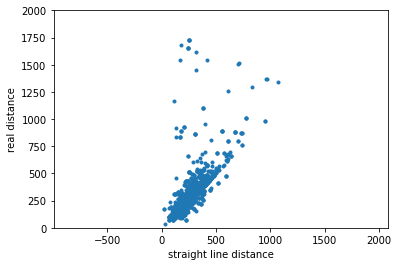

In [128]:
plt.scatter(to_find['line_distance']*1000, to_find['real_length'], marker=".")
plt.axis('equal')
plt.ylim(0,2000)
plt.xlabel("straight line distance")
plt.ylabel("real distance")

In [131]:
to_find.sort_values("real_length")

workid  line_distance  \
segment_name              publicName                              
1280POA11439_1280POA11440 1c           167_143_1       0.030805   
1280POZ00737_1280POA90816 1c           167_16_11       0.068421   
                          1             167_16_7       0.068421   
1290BOT11618_1290BOB20532 18           167_247_2       0.105634   
                          1c           167_143_1       0.105634   
                          1            167_16_12       0.105634   
                          3           167_208_10       0.105634   
1280POA11598_1280POA11600 1c           167_143_1       0.223460   
                          18          167_247_10       0.223460   
                          1            167_16_12       0.223460   
1290BOB20281_1290BOA90841 1b           167_120_1       0.064946   
1290BOB20550_1290BOB20551 7           167_243_10       0.080272   
                          33           167_253_1       0.080272   
1280POA11296_1280POA11298 18          167_247_10       0.165527   
1290BOA90841_1290DOA90842 1b           167_120_1       0.182135   
1290BOB20320_1290BOB20316 86           167_650_1       0.090547   
                          46           167_263_1       0.090547   
                          85           167_259_1       0.090547   
                          87           167_263_2       0.090547   
1290BOB20529_1290BOB20530 1c           167_16_11       0.118064   
                          3            167_208_1       0.118064   
                          18           167_247_1       0.118064   
                          1             167_16_7       0.118064   
1280POA11303_1280POA11305 18          167_247_10       0.126151   
1290BOB20071_1290BOB20128 5           167_224_13       0.071598   
                          5a           167_224_1       0.071598   
                          86           167_650_1       0.071598   
1200BOB20189_1200BOB20184 33           170_222_2       0.098692   
1290DOB20932_1290BOB20091 85           167_259_2       0.067205   
                          60           167_648_1       0.067205   
...                                          ...            ...   
1200BOB20177_1200DOY29325 1a          167_102_11       0.834573   
1290BOA56572_1290BOA05335 2           167_156_16       1.065854   
1200DOA05374_1200DOY39197 737          167_257_1       0.960670   
1200DOY39197_1200DOA05373 737         167_257_11       0.967168   
1290BOB20505_1290BOB20504 36           167_249_1       0.315152   
1200DOA91110_1200DOA90963 737          167_257_1       0.706083   
1200DOA90964_1200DOA91111 737         167_257_11       0.712563   
1290BOB20220_1290BOB20218 33          167_253_10       0.169632   
1290BOB20503_1290BOB20506 36          167_249_10       0.414642   
1200DOA91103_1200DOA91108 737          167_257_1       0.319103   
1290BOB20353_1290BOB20356 6           167_240_10       0.244342   
                          4a          167_217_12       0.244342   
                          4           167_217_10       0.244342   
                          737          167_257_1       0.244342   
1290BOB20218_1290BOB20236 33          167_253_10       0.179820   
1290BOB20352_1290BOB20353 4a          167_217_12       0.250699   
                          6           167_240_10       0.250699   
                          737          167_257_1       0.250699   
                          4           167_217_10       0.250699   
1200DOA05885_1200BOB20137 111          170_236_2       0.135165   
                          1a           167_101_1       0.135165   
1200DOA90965_1200DOA91103 737          167_257_1       0.311775   
1200DOA90891_1200DOA91105 737          167_257_1       0.300145   
1280POA11280_1280POA11260 18           167_247_1       0.202222   
1290BOA90853_1290BOA56572 2           167_156_16       0.948312   
1200DOA91107_1200DOA90964 737          167_257_1       0.435548   
1200DOA05845_1200DOA90963 737         167_257_11       0.397289   
1200DOA90963_1200DOA25